## **MRI classification with 3D CNN**

#### 1. Introduction
In this notebook we will explore simple 3D CNN classificationl model on `pytorch` from the Frontiers in Neuroscience paper: https://www.frontiersin.org/articles/10.3389/fnins.2019.00185/full. In the current notebook we follow [the paper](https://arxiv.org/pdf/2006.15969.pdf) on `3T` `T1w` MRI images from https://www.humanconnectome.org/. 

**Our goal will be to build a network for MEN and WOMEN brain classification, to explore gender influence on brain structure and find gender-specific biomarkers.**


*Proceeding with this Notebook you confirm your personal acess [to the data](https://www.humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release). 
 And your agreement on data [terms and conditions](https://www.humanconnectome.org/study/hcp-young-adult/data-use-terms).*


1. Importing needed libs


In [1]:
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import sklearn
from sklearn import metrics
from torchsummary import summary
from sklearn.model_selection import train_test_split, StratifiedKFold


%matplotlib inline

2. Mounting Google Drive to Collab Notebook. You should go with the link and enter your personal authorization code:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3. Get the data. Add a shortcut to your Google Drive for `labels.npy` and `tensors.npy`. 

Shared link: https://drive.google.com/drive/folders/1Cq35zfhqJHlmhQjNlsDIeQ71ZsT2aghv?usp=sharing

In [ ]:
data_dir = '/content/drive/MyDrive/data/seminars/anat/'

Let's watch the data. We will use `nilearn` package for the visualisation:  
https://nilearn.github.io/modules/generated/nilearn.plotting.plot_anat.html#nilearn.plotting.plot_anat 

In [ ]:
!pip  install --quiet --upgrade nilearn
import nilearn
from nilearn import plotting

     |████████████████████████████████| 4.9 MB 3.9 MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


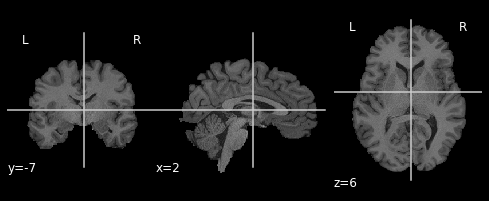

In [ ]:
img = nilearn.image.load_img(data_dir +'100408.nii')
plotting.plot_anat(img)

Questions:
1. What is the size of image (file)?
2. That is the intensity distribution of voxels?

In [ ]:
img_array = nilearn.image.get_data(img)
img_array.shape

(260, 311, 260)

#### 2. Defining training and target samples

In [ ]:
X, y = np.load(data_dir + 'tensors.npy'), \
np.load(data_dir + 'labels.npy')
X = X[:, np.newaxis, :, :, :]
print(X.shape, y.shape)

(1113, 1, 58, 70, 58) (1113,)


In [ ]:
sample_data = X[1,0,:,:,:]
X[1,0,:,:,:].shape

(58, 70, 58)

**From the sourse article:**

[The original data were too large](https://www.frontiersin.org/articles/10.3389/fnins.2019.00185/full) to train the model and it would cause RESOURCE EXAUSTED problem while training due to the insufficient of GPU memory. The GPU we used in the experiment is NVIDIAN TITAN_XP with 12G memory each. To solve the problem, we scaled the size of FA image to [58 × 70 × 58]. This procedure may lead to a better classification result, since a smaller size of the input image can provide a larger receptive field to the CNN model. In order to perform the image scaling, “dipy” (http://nipy.org/dipy/) was used to read the .nii data of FA. Then “ndimage” in the SciPy (http://www.scipy.org) was used to reduce the size of the data. 

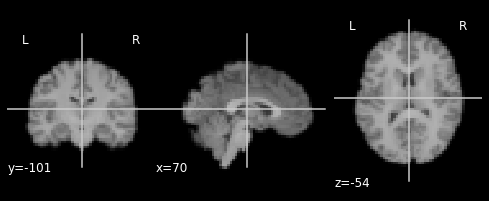

In [ ]:
sample_img = nilearn.image.new_img_like(img, sample_data)
plotting.plot_anat(sample_img)

#### 3. Defining Data Set

In [ ]:
class MriData(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(MriData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y).long()
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#### 4. Defining the CNN model architecture

[3D PCNN architecture](https://www.frontiersin.org/articles/10.3389/fnins.2019.00185/full)
![model](https://www.frontiersin.org/files/Articles/442577/fnins-13-00185-HTML/image_m/fnins-13-00185-g001.jpg)

At first check if we have GPU onborad:

In [2]:
 torch.cuda.is_available()

True

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [6]:
#Dropout
## Hidden layers 1, 2 and 3
hidden = lambda c_in, c_out: nn.Sequential(
    nn.Conv3d(c_in, c_out, (3,3,3)), # Convolutional layer
    nn.BatchNorm3d(c_out), # Batch Normalization layer
    nn.ReLU(), # Activational layer
    nn.MaxPool3d(2), # Pooling layer
    nn.Dropout3d(0,2)
)

class MriNet(nn.Module):
    def __init__(self, c):
        super(MriNet, self).__init__()
        self.hidden1 = hidden(1, c)
        self.hidden2 = hidden(c, 2*c)
        self.hidden3 = hidden(2*c, 4*c)
        self.linear = nn.Linear(128*5*7*5, 2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = F.log_softmax(x, dim=1)
        return x

torch.manual_seed(1)
np.random.seed(1)

c = 32

In [5]:
c = 32
model = MriNet(c).to(device)
summary(model, (1, 58, 70, 58))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 56, 68, 56]             896
       BatchNorm3d-2       [-1, 32, 56, 68, 56]              64
              ReLU-3       [-1, 32, 56, 68, 56]               0
         MaxPool3d-4       [-1, 32, 28, 34, 28]               0
         Dropout3d-5       [-1, 32, 28, 34, 28]               0
            Conv3d-6       [-1, 64, 26, 32, 26]          55,360
       BatchNorm3d-7       [-1, 64, 26, 32, 26]             128
              ReLU-8       [-1, 64, 26, 32, 26]               0
         MaxPool3d-9       [-1, 64, 13, 16, 13]               0
        Dropout3d-10       [-1, 64, 13, 16, 13]               0
           Conv3d-11      [-1, 128, 11, 14, 11]         221,312
      BatchNorm3d-12      [-1, 128, 11, 14, 11]             256
             ReLU-13      [-1, 128, 11, 14, 11]               0
        MaxPool3d-14         [-1, 128, 

#### 5. Training the model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42) 

train_dataset = MriData(X_train, y_train)
test_dataset = MriData(X_test, y_test)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=28, shuffle=False) 

In [ ]:
CHECKPOINTS_DIR =  data_dir +'/checkpoints'

In [ ]:
from tqdm import tqdm

def get_accuracy(net, data_loader):
    net.eval()
    correct = 0
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        del data, target
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy.item()

def get_loss(net, data_loader):
    net.eval()
    loss = 0 
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        loss += criterion(out, target).item()*len(data)

        del data, target, out 

    return loss / len(data_loader.dataset)


def train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save=False):
    best_val_loss = 100_000
    best_model = None
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    train_loss_list.append(get_loss(net, train_loader))
    val_loss_list.append(get_loss(net, val_loader))
    train_acc_list.append(get_accuracy(net, train_loader))
    val_acc_list.append(get_accuracy(net, val_loader))
    if verbose:
        print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(0, epochs, train_loss_list[-1], val_loss_list[-1]))

    net.to(device)
    for epoch in tqdm(range(1, epochs+1)):
        net.train()
        for X, y in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = net(X)
            
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            del X, y, out, loss #freeing gpu space
            
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        for X, y in val_loader:
            # Compute the validation loss
            X, y = X.to(device), y.to(device)
            out = net(X)
            del X, y, out #freeing gpu space
         
        if scheduler is not None:
            scheduler.step()
        
        
        train_loss_list.append(get_loss(net, train_loader))
        val_loss_list.append(get_loss(net, val_loader))
        train_acc_list.append(get_accuracy(net, train_loader))
        val_acc_list.append(get_accuracy(net, val_loader))

        if save and val_loss_list[-1] < best_val_loss:
            torch.save(net.state_dict(), CHECKPOINTS_DIR+'best_model')
        freq = 1
        if verbose and epoch%freq==0:
            print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_loss_list[-1], val_loss_list[-1]))
        
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list    

In [ ]:
#With roc_auc metric
# timing
from tqdm import tqdm

def get_roc_auc(net, data_loader):
    net.eval()
    correct = 0
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        out_numpy = out.cpu().detach().numpy()
        pred = np.exp(out_numpy[:, 1])
        del data

    try:
      accuracy = metrics.roc_auc_score(target.cpu(), pred)
    except ValueError:
      accuracy = 0.0001

    #del target
    return accuracy

def get_loss(net, data_loader):
    net.eval()
    loss = 0 
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        loss += criterion(out, target).item()*len(data)

        del data, target, out 

    return loss / len(data_loader.dataset)


def train_roc_auc(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save=False):
    best_val_loss = 100_000
    best_model = None
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    train_loss_list.append(get_loss(net, train_loader))
    val_loss_list.append(get_loss(net, val_loader))
    train_acc_list.append(get_roc_auc(net, train_loader))
    val_acc_list.append(get_roc_auc(net, val_loader))
    if verbose:
        print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(0, epochs, train_loss_list[-1], val_loss_list[-1]))

    net.to(device)
    for epoch in tqdm(range(1, epochs+1)):
        net.train()
        for X, y in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = net(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            del X, y, out, loss #freeing gpu space
            
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        for X, y in val_loader:
            # Compute the validation loss
            X, y = X.to(device), y.to(device)
            out = net(X)
            del X, y, out #freeing gpu space
         
        if scheduler is not None:
            scheduler.step()
        
        
        train_loss_list.append(get_loss(net, train_loader))
        val_loss_list.append(get_loss(net, val_loader))
        train_acc_list.append(get_roc_auc(net, train_loader))
        val_acc_list.append(get_roc_auc(net, val_loader))

        if save and val_loss_list[-1] < best_val_loss:
            torch.save(net.state_dict(), CHECKPOINTS_DIR+'best_model')
        freq = 1
        if verbose and epoch%freq==0:
            print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_loss_list[-1], val_loss_list[-1]))
        
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list    

##### Training first **20 epochs**:


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = MriNet(c).to(device)

criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

In [ ]:
# training will take ~3 min
#train model with accuracy metric
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 20

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False) 

Epoch 00/20 || Loss:  Train 39.7695 | Validation 39.8970


  5%|▌         | 1/20 [00:23<07:35, 23.95s/it]

Epoch 01/20 || Loss:  Train 1.7140 | Validation 1.8952


 10%|█         | 2/20 [00:48<07:12, 24.03s/it]

Epoch 02/20 || Loss:  Train 0.3202 | Validation 0.3871


 15%|█▌        | 3/20 [01:12<06:50, 24.14s/it]

Epoch 03/20 || Loss:  Train 0.3107 | Validation 0.3986


 20%|██        | 4/20 [01:36<06:27, 24.24s/it]

Epoch 04/20 || Loss:  Train 0.2393 | Validation 0.2897


 25%|██▌       | 5/20 [02:01<06:04, 24.30s/it]

Epoch 05/20 || Loss:  Train 0.2217 | Validation 0.2887


 30%|███       | 6/20 [02:25<05:40, 24.35s/it]

Epoch 06/20 || Loss:  Train 0.2188 | Validation 0.2842


 35%|███▌      | 7/20 [02:49<05:16, 24.36s/it]

Epoch 07/20 || Loss:  Train 0.2179 | Validation 0.2867


 40%|████      | 8/20 [03:14<04:52, 24.38s/it]

Epoch 08/20 || Loss:  Train 0.2153 | Validation 0.2816


 45%|████▌     | 9/20 [03:38<04:28, 24.39s/it]

Epoch 09/20 || Loss:  Train 0.2171 | Validation 0.2907


 50%|█████     | 10/20 [04:03<04:03, 24.40s/it]

Epoch 10/20 || Loss:  Train 0.2206 | Validation 0.2990


 55%|█████▌    | 11/20 [04:27<03:39, 24.41s/it]

Epoch 11/20 || Loss:  Train 0.2107 | Validation 0.2816


 60%|██████    | 12/20 [04:52<03:15, 24.40s/it]

Epoch 12/20 || Loss:  Train 0.2082 | Validation 0.2775


 65%|██████▌   | 13/20 [05:16<02:50, 24.42s/it]

Epoch 13/20 || Loss:  Train 0.2073 | Validation 0.2744


 70%|███████   | 14/20 [05:40<02:26, 24.42s/it]

Epoch 14/20 || Loss:  Train 0.2081 | Validation 0.2747


 75%|███████▌  | 15/20 [06:05<02:02, 24.42s/it]

Epoch 15/20 || Loss:  Train 0.2057 | Validation 0.2728


 80%|████████  | 16/20 [06:29<01:37, 24.43s/it]

Epoch 16/20 || Loss:  Train 0.2019 | Validation 0.2728


 85%|████████▌ | 17/20 [06:54<01:13, 24.43s/it]

Epoch 17/20 || Loss:  Train 0.2016 | Validation 0.2743


 90%|█████████ | 18/20 [07:18<00:48, 24.43s/it]

Epoch 18/20 || Loss:  Train 0.2014 | Validation 0.2745


 95%|█████████▌| 19/20 [07:43<00:24, 24.43s/it]

Epoch 19/20 || Loss:  Train 0.2011 | Validation 0.2730


100%|██████████| 20/20 [08:07<00:00, 24.37s/it]

Epoch 20/20 || Loss:  Train 0.2010 | Validation 0.2740


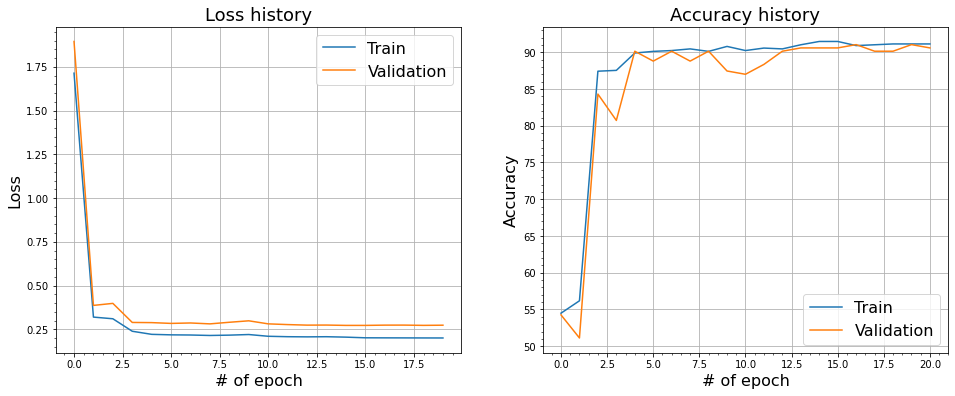

In [ ]:
plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.title('Loss history', fontsize=18)
plt.plot(train_loss_list[1:], label='Train')
plt.plot(val_loss_list[1:], label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy history', fontsize=18)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()

##### K-Fold model validation:

Questions:
1. What is the purpose of K-Fold in that experiment setting?
2. Can we afford cross-validation in regular DL?

In [ ]:
# execute for ~ 5 min
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cross_vall_acc_list = []
j = 0

for train_index, test_index in skf.split(X, y):
    print('Doing {} split'.format(j))
    j += 1

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_dataset = MriData(X_train, y_train)
    test_dataset = MriData(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=28, shuffle=False) 
    
    torch.manual_seed(1)
    np.random.seed(1)

    c = 32
    model = MriNet(c).to(device)
    criterion = nn.NLLLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

    train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False, verbose=False) 
    cross_vall_acc_list.append(get_accuracy(model, val_loader))


Doing 0 split


100%|██████████| 20/20 [07:42<00:00, 23.12s/it]


Doing 1 split


100%|██████████| 20/20 [07:42<00:00, 23.13s/it]


Doing 2 split


100%|██████████| 20/20 [07:44<00:00, 23.24s/it]


In [ ]:
print('Average cross-validation accuracy (3-folds):', sum(cross_vall_acc_list)/len(cross_vall_acc_list))

Average cross-validation accuracy (3-folds): 89.75741322835286


In [ ]:
#Save model
PATH = '/content/drive/MyDrive/Учеба/Diplom/model_classification_weights'
torch.save(model, PATH)

### Train model with ROC_AUC metric

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#train model with roc_auc metric
model = MriNet(c).to(device)

criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

In [ ]:
# training will take ~3 min
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 20

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train_roc_auc(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False) 

Epoch 00/20 || Loss:  Train 39.7695 | Validation 39.8970


  5%|▌         | 1/20 [00:24<07:39, 24.18s/it]

Epoch 01/20 || Loss:  Train 1.7130 | Validation 1.8943


 10%|█         | 2/20 [00:48<07:17, 24.28s/it]

Epoch 02/20 || Loss:  Train 0.3200 | Validation 0.3869


 15%|█▌        | 3/20 [01:13<06:54, 24.38s/it]

Epoch 03/20 || Loss:  Train 0.3121 | Validation 0.4008


 20%|██        | 4/20 [01:37<06:30, 24.43s/it]

Epoch 04/20 || Loss:  Train 0.2396 | Validation 0.2899


 25%|██▌       | 5/20 [02:01<06:06, 24.43s/it]

Epoch 05/20 || Loss:  Train 0.2220 | Validation 0.2893


 30%|███       | 6/20 [02:26<05:42, 24.44s/it]

Epoch 06/20 || Loss:  Train 0.2189 | Validation 0.2844


 35%|███▌      | 7/20 [02:50<05:17, 24.42s/it]

Epoch 07/20 || Loss:  Train 0.2179 | Validation 0.2866


 40%|████      | 8/20 [03:15<04:53, 24.43s/it]

Epoch 08/20 || Loss:  Train 0.2154 | Validation 0.2815


 45%|████▌     | 9/20 [03:39<04:28, 24.43s/it]

Epoch 09/20 || Loss:  Train 0.2171 | Validation 0.2905


 50%|█████     | 10/20 [04:04<04:04, 24.44s/it]

Epoch 10/20 || Loss:  Train 0.2207 | Validation 0.2989


 55%|█████▌    | 11/20 [04:28<03:39, 24.44s/it]

Epoch 11/20 || Loss:  Train 0.2108 | Validation 0.2817


 60%|██████    | 12/20 [04:53<03:15, 24.44s/it]

Epoch 12/20 || Loss:  Train 0.2083 | Validation 0.2775


 65%|██████▌   | 13/20 [05:17<02:51, 24.44s/it]

Epoch 13/20 || Loss:  Train 0.2075 | Validation 0.2744


 70%|███████   | 14/20 [05:41<02:26, 24.44s/it]

Epoch 14/20 || Loss:  Train 0.2082 | Validation 0.2747


 75%|███████▌  | 15/20 [06:06<02:02, 24.44s/it]

Epoch 15/20 || Loss:  Train 0.2060 | Validation 0.2730


 80%|████████  | 16/20 [06:30<01:37, 24.44s/it]

Epoch 16/20 || Loss:  Train 0.2021 | Validation 0.2729


 85%|████████▌ | 17/20 [06:55<01:13, 24.46s/it]

Epoch 17/20 || Loss:  Train 0.2018 | Validation 0.2744


 90%|█████████ | 18/20 [07:19<00:48, 24.46s/it]

Epoch 18/20 || Loss:  Train 0.2016 | Validation 0.2746


 95%|█████████▌| 19/20 [07:44<00:24, 24.47s/it]

Epoch 19/20 || Loss:  Train 0.2013 | Validation 0.2731


100%|██████████| 20/20 [08:08<00:00, 24.43s/it]

Epoch 20/20 || Loss:  Train 0.2011 | Validation 0.2740


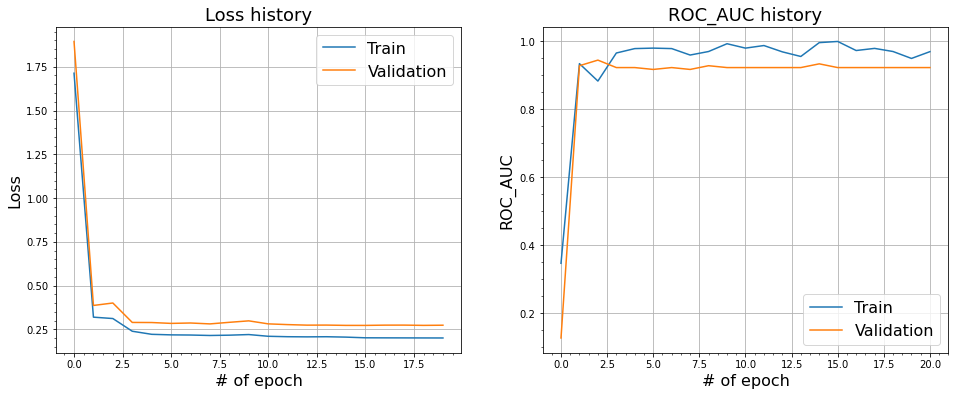

In [ ]:
plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.title('Loss history', fontsize=18)
plt.plot(train_loss_list[1:], label='Train')
plt.plot(val_loss_list[1:], label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()

plt.subplot(1, 2, 2)
plt.title('ROC_AUC history', fontsize=18)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('ROC_AUC', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()

In [ ]:
#Save model with roc_auc
PATH = '/content/drive/MyDrive/Учеба/Diplom/model_classification_weights_roc_auc'
torch.save(model, PATH)

### ABIDE data

In [ ]:
selected_all_sum_tensor = torch.load('/content/drive/MyDrive/abideI-mni/T1_ss_mni_64_all-sites-I').float()
selected_all_sum_tensor = F.pad(selected_all_sum_tensor, pad=(6,6,6,6,6,6))

print(selected_all_sum_tensor.shape)

selected_all_sum_tensor = selected_all_sum_tensor[..., 10:68, 0:70, 18:76] 
selected_all_sum_tensor.shape

torch.Size([1093, 76, 76, 76])


torch.Size([1093, 58, 70, 58])

In [ ]:
selected_all_sum_tensor = selected_all_sum_tensor[:, np.newaxis, :, :, :]

In [ ]:
target = torch.load('/content/drive/MyDrive/abideI-mni/sexes_all-sites-I')

In [ ]:
new_target = []
for t in target:
  if t == 1:
    t = 0
    new_target.append(t)
  else:
    t = 1
    new_target.append(t)
target = torch.tensor(new_target)

In [ ]:
class MriData(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(MriData, self).__init__()
        self.X = X.type(torch.float32)
        self.y = y.type(torch.long)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def get_labels(self):
        return self.y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(selected_all_sum_tensor, target, test_size=0.20, random_state=42) 

train_dataset = MriData(X_train, y_train)
test_dataset = MriData(X_test, y_test)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=45, shuffle=True) 
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=28, shuffle=False) 

In [ ]:
#train model with accuracy metric
model = MriNet(c).to(device)

criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

In [ ]:
# training will take ~3 min
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 20

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False) 

Epoch 00/20 || Loss:  Train 83.7573 | Validation 72.3414


  5%|▌         | 1/20 [00:23<07:34, 23.93s/it]

Epoch 01/20 || Loss:  Train 0.5232 | Validation 0.5120


 10%|█         | 2/20 [00:48<07:12, 24.03s/it]

Epoch 02/20 || Loss:  Train 0.4680 | Validation 0.4643


 15%|█▌        | 3/20 [01:12<06:48, 24.05s/it]

Epoch 03/20 || Loss:  Train 0.5685 | Validation 0.5242


 20%|██        | 4/20 [01:36<06:24, 24.01s/it]

Epoch 04/20 || Loss:  Train 0.4960 | Validation 0.4867


 25%|██▌       | 5/20 [01:59<05:59, 23.98s/it]

Epoch 05/20 || Loss:  Train 0.4120 | Validation 0.4235


 30%|███       | 6/20 [02:23<05:35, 23.96s/it]

Epoch 06/20 || Loss:  Train 0.4069 | Validation 0.4195


 35%|███▌      | 7/20 [02:47<05:11, 23.95s/it]

Epoch 07/20 || Loss:  Train 0.4127 | Validation 0.4222


 40%|████      | 8/20 [03:11<04:47, 23.94s/it]

Epoch 08/20 || Loss:  Train 0.4084 | Validation 0.4205


 45%|████▌     | 9/20 [03:35<04:23, 23.93s/it]

Epoch 09/20 || Loss:  Train 0.4062 | Validation 0.4209


 50%|█████     | 10/20 [03:59<03:59, 23.93s/it]

Epoch 10/20 || Loss:  Train 0.4015 | Validation 0.4166


 55%|█████▌    | 11/20 [04:23<03:35, 23.93s/it]

Epoch 11/20 || Loss:  Train 0.4179 | Validation 0.4322


 60%|██████    | 12/20 [04:47<03:11, 23.92s/it]

Epoch 12/20 || Loss:  Train 0.4118 | Validation 0.4268


 65%|██████▌   | 13/20 [05:11<02:47, 23.92s/it]

Epoch 13/20 || Loss:  Train 0.3997 | Validation 0.4151


 70%|███████   | 14/20 [05:35<02:23, 23.92s/it]

Epoch 14/20 || Loss:  Train 0.4006 | Validation 0.4155


 75%|███████▌  | 15/20 [05:59<01:59, 23.93s/it]

Epoch 15/20 || Loss:  Train 0.4007 | Validation 0.4172


 80%|████████  | 16/20 [06:23<01:35, 23.93s/it]

Epoch 16/20 || Loss:  Train 0.3989 | Validation 0.4165


 85%|████████▌ | 17/20 [06:47<01:11, 23.93s/it]

Epoch 17/20 || Loss:  Train 0.3986 | Validation 0.4174


 90%|█████████ | 18/20 [07:10<00:47, 23.93s/it]

Epoch 18/20 || Loss:  Train 0.3975 | Validation 0.4140


 95%|█████████▌| 19/20 [07:34<00:23, 23.93s/it]

Epoch 19/20 || Loss:  Train 0.3975 | Validation 0.4154


100%|██████████| 20/20 [07:58<00:00, 23.94s/it]

Epoch 20/20 || Loss:  Train 0.3974 | Validation 0.4145


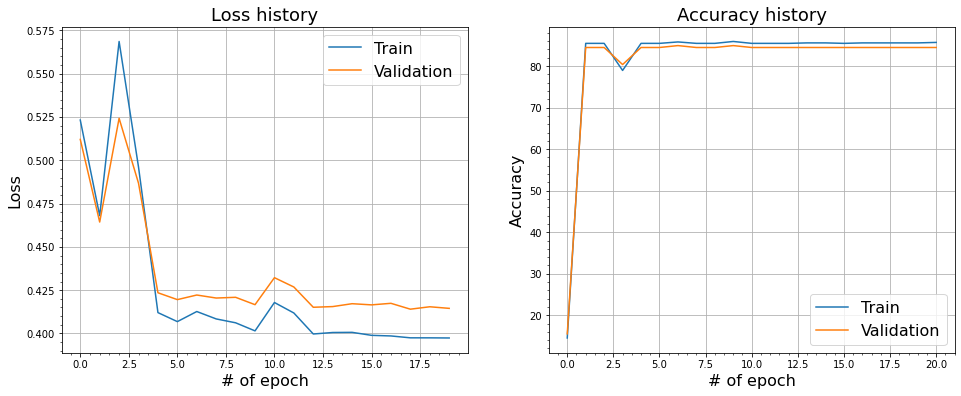

In [ ]:
plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.title('Loss history', fontsize=18)
plt.plot(train_loss_list[1:], label='Train')
plt.plot(val_loss_list[1:], label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy history', fontsize=18)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()

##### K-Fold model validation:

In [ ]:
# execute for ~ 5 min
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cross_vall_acc_list = []
j = 0

for train_index, test_index in skf.split(selected_all_sum_tensor, target):
    print('Doing {} split'.format(j))
    j += 1

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_dataset = MriData(X_train, y_train)
    test_dataset = MriData(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=28, shuffle=False) 
    
    torch.manual_seed(1)
    np.random.seed(1)

    c = 32
    model = MriNet(c).to(device)
    criterion = nn.NLLLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

    train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False, verbose=False) 
    cross_vall_acc_list.append(get_accuracy(model, val_loader))


Doing 0 split


100%|██████████| 20/20 [07:32<00:00, 22.63s/it]


Doing 1 split


100%|██████████| 20/20 [07:34<00:00, 22.74s/it]


Doing 2 split


100%|██████████| 20/20 [07:36<00:00, 22.82s/it]


In [ ]:
print('Average cross-validation accuracy (3-folds):', sum(cross_vall_acc_list)/len(cross_vall_acc_list))

Average cross-validation accuracy (3-folds): 90.02709706624348


In [ ]:
#train model with roc_auc metric
model = MriNet(c).to(device)

criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

In [ ]:
# training will take ~3 min
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 20

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train_roc_auc(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False) 

Epoch 00/20 || Loss:  Train 15.5826 | Validation 14.6674


  5%|▌         | 1/20 [00:23<07:30, 23.70s/it]

Epoch 01/20 || Loss:  Train 0.6728 | Validation 0.6018


 10%|█         | 2/20 [00:47<07:07, 23.77s/it]

Epoch 02/20 || Loss:  Train 0.4349 | Validation 0.4368


 15%|█▌        | 3/20 [01:11<06:44, 23.80s/it]

Epoch 03/20 || Loss:  Train 0.4293 | Validation 0.4310


 20%|██        | 4/20 [01:35<06:21, 23.84s/it]

Epoch 04/20 || Loss:  Train 0.4862 | Validation 0.4739


 25%|██▌       | 5/20 [01:59<05:57, 23.86s/it]

Epoch 05/20 || Loss:  Train 0.4041 | Validation 0.4194


 30%|███       | 6/20 [02:23<05:34, 23.88s/it]

Epoch 06/20 || Loss:  Train 0.4035 | Validation 0.4178


 35%|███▌      | 7/20 [02:46<05:10, 23.89s/it]

Epoch 07/20 || Loss:  Train 0.4131 | Validation 0.4241


 40%|████      | 8/20 [03:10<04:46, 23.89s/it]

Epoch 08/20 || Loss:  Train 0.4055 | Validation 0.4205


 45%|████▌     | 9/20 [03:34<04:22, 23.89s/it]

Epoch 09/20 || Loss:  Train 0.4061 | Validation 0.4224


 50%|█████     | 10/20 [03:58<03:58, 23.89s/it]

Epoch 10/20 || Loss:  Train 0.4010 | Validation 0.4184


 55%|█████▌    | 11/20 [04:22<03:35, 23.90s/it]

Epoch 11/20 || Loss:  Train 0.4118 | Validation 0.4298


 60%|██████    | 12/20 [04:46<03:11, 23.89s/it]

Epoch 12/20 || Loss:  Train 0.4082 | Validation 0.4270


 65%|██████▌   | 13/20 [05:10<02:47, 23.90s/it]

Epoch 13/20 || Loss:  Train 0.3986 | Validation 0.4167


 70%|███████   | 14/20 [05:34<02:23, 23.90s/it]

Epoch 14/20 || Loss:  Train 0.4005 | Validation 0.4175


 75%|███████▌  | 15/20 [05:58<01:59, 23.90s/it]

Epoch 15/20 || Loss:  Train 0.3970 | Validation 0.4167


 80%|████████  | 16/20 [06:22<01:35, 23.89s/it]

Epoch 16/20 || Loss:  Train 0.3996 | Validation 0.4194


 85%|████████▌ | 17/20 [06:45<01:11, 23.90s/it]

Epoch 17/20 || Loss:  Train 0.3991 | Validation 0.4200


 90%|█████████ | 18/20 [07:09<00:47, 23.89s/it]

Epoch 18/20 || Loss:  Train 0.3963 | Validation 0.4155


 95%|█████████▌| 19/20 [07:33<00:23, 23.89s/it]

Epoch 19/20 || Loss:  Train 0.3959 | Validation 0.4165


100%|██████████| 20/20 [07:57<00:00, 23.88s/it]

Epoch 20/20 || Loss:  Train 0.3963 | Validation 0.4158


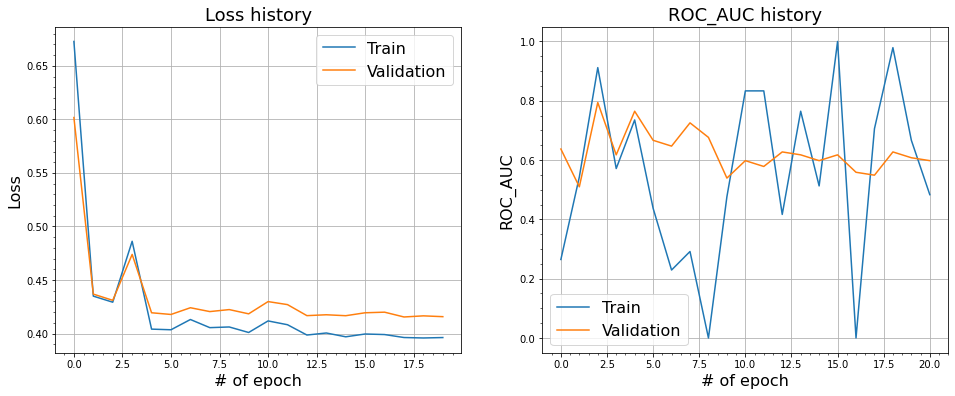

In [ ]:
plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.title('Loss history', fontsize=18)
plt.plot(train_loss_list[1:], label='Train')
plt.plot(val_loss_list[1:], label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()

plt.subplot(1, 2, 2)
plt.title('ROC_AUC history', fontsize=18)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('ROC_AUC', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()

### Make balanced Dataset

In [ ]:
#Sampler Class for imbalanced datasets
from typing import Callable

import pandas as pd
import torch
import torch.utils.data
import torchvision


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices: a list of indices
        num_samples: number of samples to draw
        callback_get_label: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices: list = None, num_samples: int = None, callback_get_label: Callable = None):
        # if indices is not provided, all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        # distribution of classes in the dataset
        df = pd.DataFrame()
        df["label"] = self._get_labels(dataset)
        df.index = self.indices
        df = df.sort_index()

        label_to_count = df["label"].value_counts()

        weights = 1.0 / label_to_count[df["label"]]

        self.weights = torch.DoubleTensor(weights.to_list())

    def _get_labels(self, dataset):
        if self.callback_get_label:
            return self.callback_get_label(dataset)
        elif isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels.tolist()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return [x[1] for x in dataset.imgs]
        elif isinstance(dataset, torchvision.datasets.DatasetFolder):
            return dataset.samples[:][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[:][1]
        elif isinstance(dataset, torch.utils.data.Dataset):
            return dataset.get_labels()
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [ ]:
train_sampler = ImbalancedDatasetSampler(train_dataset)
val_sampler = ImbalancedDatasetSampler(test_dataset)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=45, shuffle=False, sampler=train_sampler) 
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=28, shuffle=False, sampler = val_sampler) 

In [ ]:
#train model with accuracy metric and imbalandes sampler for dataloader
model = MriNet(c).to(device)

criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

In [ ]:
# training will take ~3 min
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 20

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False) 

Epoch 00/20 || Loss:  Train 20.6944 | Validation 16.4504


  5%|▌         | 1/20 [00:23<07:31, 23.76s/it]

Epoch 01/20 || Loss:  Train 2.8043 | Validation 2.3432


 10%|█         | 2/20 [00:47<07:09, 23.84s/it]

Epoch 02/20 || Loss:  Train 1.1202 | Validation 1.2562


 15%|█▌        | 3/20 [01:11<06:45, 23.88s/it]

Epoch 03/20 || Loss:  Train 0.7451 | Validation 0.7710


 20%|██        | 4/20 [01:35<06:22, 23.90s/it]

Epoch 04/20 || Loss:  Train 0.8672 | Validation 0.8522


 25%|██▌       | 5/20 [01:59<05:58, 23.93s/it]

Epoch 05/20 || Loss:  Train 0.8992 | Validation 0.9299


 30%|███       | 6/20 [02:23<05:35, 23.95s/it]

Epoch 06/20 || Loss:  Train 0.6652 | Validation 0.6737


 35%|███▌      | 7/20 [02:47<05:11, 23.95s/it]

Epoch 07/20 || Loss:  Train 0.6655 | Validation 0.7130


 40%|████      | 8/20 [03:11<04:47, 23.95s/it]

Epoch 08/20 || Loss:  Train 0.6572 | Validation 0.6884


 45%|████▌     | 9/20 [03:35<04:23, 23.96s/it]

Epoch 09/20 || Loss:  Train 0.6618 | Validation 0.6867


 50%|█████     | 10/20 [03:59<03:59, 23.96s/it]

Epoch 10/20 || Loss:  Train 0.6664 | Validation 0.6906


 55%|█████▌    | 11/20 [04:23<03:35, 23.95s/it]

Epoch 11/20 || Loss:  Train 0.6753 | Validation 0.6846


 60%|██████    | 12/20 [04:47<03:11, 23.96s/it]

Epoch 12/20 || Loss:  Train 0.6851 | Validation 0.6881


 65%|██████▌   | 13/20 [05:11<02:47, 23.97s/it]

Epoch 13/20 || Loss:  Train 0.6602 | Validation 0.6668


 70%|███████   | 14/20 [05:35<02:23, 23.97s/it]

Epoch 14/20 || Loss:  Train 0.6652 | Validation 0.6752


 75%|███████▌  | 15/20 [05:59<01:59, 23.97s/it]

Epoch 15/20 || Loss:  Train 0.6767 | Validation 0.6826


 80%|████████  | 16/20 [06:23<01:35, 23.97s/it]

Epoch 16/20 || Loss:  Train 0.6596 | Validation 0.6853


 85%|████████▌ | 17/20 [06:47<01:11, 23.97s/it]

Epoch 17/20 || Loss:  Train 0.6603 | Validation 0.6744


 90%|█████████ | 18/20 [07:11<00:47, 23.97s/it]

Epoch 18/20 || Loss:  Train 0.6584 | Validation 0.6951


 95%|█████████▌| 19/20 [07:35<00:23, 23.96s/it]

Epoch 19/20 || Loss:  Train 0.6543 | Validation 0.6829


100%|██████████| 20/20 [07:58<00:00, 23.95s/it]

Epoch 20/20 || Loss:  Train 0.6471 | Validation 0.6824


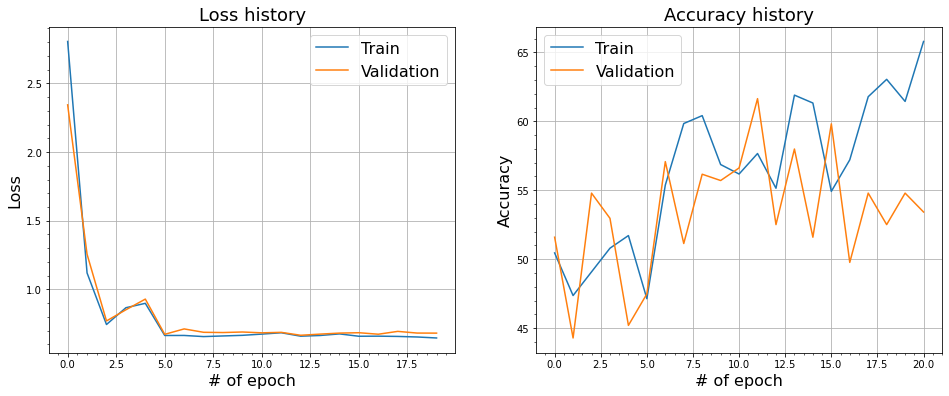

In [ ]:
plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.title('Loss history', fontsize=18)
plt.plot(train_loss_list[1:], label='Train')
plt.plot(val_loss_list[1:], label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy history', fontsize=18)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()

In [ ]:
#train model with roc_auc metric and imbalandes sampler for dataloader
model = MriNet(c).to(device)

criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

In [ ]:
# training will take ~3 min
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 20

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train_roc_auc(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False) 

Epoch 00/20 || Loss:  Train 61.3056 | Validation 49.5618


  5%|▌         | 1/20 [00:23<07:28, 23.60s/it]

Epoch 01/20 || Loss:  Train 0.7553 | Validation 0.7539


 10%|█         | 2/20 [00:47<07:05, 23.66s/it]

Epoch 02/20 || Loss:  Train 1.4191 | Validation 1.6911


 15%|█▌        | 3/20 [01:11<06:43, 23.73s/it]

Epoch 03/20 || Loss:  Train 0.7976 | Validation 0.7844


 20%|██        | 4/20 [01:34<06:20, 23.76s/it]

Epoch 04/20 || Loss:  Train 0.7153 | Validation 0.7317


 25%|██▌       | 5/20 [01:58<05:57, 23.80s/it]

Epoch 05/20 || Loss:  Train 0.6599 | Validation 0.6945


 30%|███       | 6/20 [02:22<05:33, 23.84s/it]

Epoch 06/20 || Loss:  Train 0.6280 | Validation 0.6843


 35%|███▌      | 7/20 [02:46<05:10, 23.86s/it]

Epoch 07/20 || Loss:  Train 0.6371 | Validation 0.6916


 40%|████      | 8/20 [03:10<04:46, 23.87s/it]

Epoch 08/20 || Loss:  Train 0.6231 | Validation 0.6751


 45%|████▌     | 9/20 [03:34<04:22, 23.89s/it]

Epoch 09/20 || Loss:  Train 0.6315 | Validation 0.6866


 50%|█████     | 10/20 [03:58<03:59, 23.90s/it]

Epoch 10/20 || Loss:  Train 0.6287 | Validation 0.7003


 55%|█████▌    | 11/20 [04:22<03:35, 23.91s/it]

Epoch 11/20 || Loss:  Train 0.6227 | Validation 0.6757


 60%|██████    | 12/20 [04:46<03:11, 23.91s/it]

Epoch 12/20 || Loss:  Train 0.6251 | Validation 0.6601


 65%|██████▌   | 13/20 [05:10<02:47, 23.90s/it]

Epoch 13/20 || Loss:  Train 0.6037 | Validation 0.6489


 70%|███████   | 14/20 [05:34<02:23, 23.91s/it]

Epoch 14/20 || Loss:  Train 0.6055 | Validation 0.6732


 75%|███████▌  | 15/20 [05:57<01:59, 23.92s/it]

Epoch 15/20 || Loss:  Train 0.5926 | Validation 0.6644


 80%|████████  | 16/20 [06:21<01:35, 23.92s/it]

Epoch 16/20 || Loss:  Train 0.6105 | Validation 0.6886


 85%|████████▌ | 17/20 [06:45<01:11, 23.92s/it]

Epoch 17/20 || Loss:  Train 0.6004 | Validation 0.6469


 90%|█████████ | 18/20 [07:09<00:47, 23.92s/it]

Epoch 18/20 || Loss:  Train 0.6063 | Validation 0.7007


 95%|█████████▌| 19/20 [07:33<00:23, 23.91s/it]

Epoch 19/20 || Loss:  Train 0.5960 | Validation 0.6676


100%|██████████| 20/20 [07:57<00:00, 23.88s/it]

Epoch 20/20 || Loss:  Train 0.5883 | Validation 0.7178


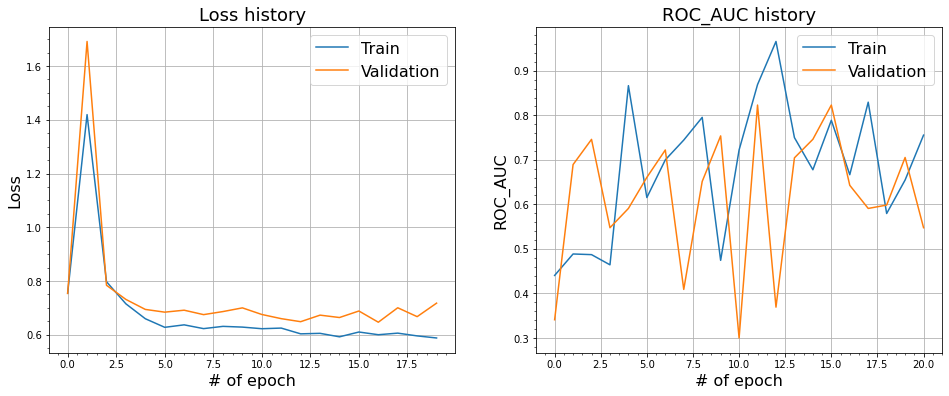

In [ ]:
plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.title('Loss history', fontsize=18)
plt.plot(train_loss_list[1:], label='Train')
plt.plot(val_loss_list[1:], label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()

plt.subplot(1, 2, 2)
plt.title('ROC_AUC history', fontsize=18)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('ROC_AUC', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()

### Train predtrained model on 1-st Datset

In [ ]:
#Predtrained model on 1st Dataset with accuracy metric and sampler for imbalanced Dataset
model = torch.load('/content/drive/MyDrive/Учеба/Diplom/model_classification_weights')

criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

In [ ]:
# training will take ~3 min
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 20

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False) 

Epoch 00/20 || Loss:  Train 1.3345 | Validation 1.1891


  5%|▌         | 1/20 [00:23<07:34, 23.93s/it]

Epoch 01/20 || Loss:  Train 1.4143 | Validation 1.2751


 10%|█         | 2/20 [00:47<07:10, 23.92s/it]

Epoch 02/20 || Loss:  Train 0.8893 | Validation 1.0063


 15%|█▌        | 3/20 [01:11<06:46, 23.92s/it]

Epoch 03/20 || Loss:  Train 0.7114 | Validation 0.7489


 20%|██        | 4/20 [01:35<06:22, 23.92s/it]

Epoch 04/20 || Loss:  Train 0.6743 | Validation 0.6761


 25%|██▌       | 5/20 [01:59<05:58, 23.92s/it]

Epoch 05/20 || Loss:  Train 0.8583 | Validation 0.9038


 30%|███       | 6/20 [02:23<05:34, 23.91s/it]

Epoch 06/20 || Loss:  Train 0.6738 | Validation 0.6645


 35%|███▌      | 7/20 [02:47<05:10, 23.91s/it]

Epoch 07/20 || Loss:  Train 0.6800 | Validation 0.7104


 40%|████      | 8/20 [03:11<04:46, 23.92s/it]

Epoch 08/20 || Loss:  Train 0.6620 | Validation 0.6820


 45%|████▌     | 9/20 [03:35<04:23, 23.92s/it]

Epoch 09/20 || Loss:  Train 0.6668 | Validation 0.6806


 50%|█████     | 10/20 [03:59<03:59, 23.92s/it]

Epoch 10/20 || Loss:  Train 0.6602 | Validation 0.6896


 55%|█████▌    | 11/20 [04:23<03:35, 23.92s/it]

Epoch 11/20 || Loss:  Train 0.6658 | Validation 0.6916


 60%|██████    | 12/20 [04:47<03:11, 23.92s/it]

Epoch 12/20 || Loss:  Train 0.6663 | Validation 0.6736


 65%|██████▌   | 13/20 [05:10<02:47, 23.92s/it]

Epoch 13/20 || Loss:  Train 0.6596 | Validation 0.6597


 70%|███████   | 14/20 [05:34<02:23, 23.91s/it]

Epoch 14/20 || Loss:  Train 0.6737 | Validation 0.6632


 75%|███████▌  | 15/20 [05:58<01:59, 23.92s/it]

Epoch 15/20 || Loss:  Train 0.6704 | Validation 0.6685


 80%|████████  | 16/20 [06:22<01:35, 23.92s/it]

Epoch 16/20 || Loss:  Train 0.6645 | Validation 0.6809


 85%|████████▌ | 17/20 [06:46<01:11, 23.93s/it]

Epoch 17/20 || Loss:  Train 0.6629 | Validation 0.6607


 90%|█████████ | 18/20 [07:10<00:47, 23.94s/it]

Epoch 18/20 || Loss:  Train 0.6610 | Validation 0.6945


 95%|█████████▌| 19/20 [07:34<00:23, 23.94s/it]

Epoch 19/20 || Loss:  Train 0.6587 | Validation 0.6635


100%|██████████| 20/20 [07:58<00:00, 23.93s/it]

Epoch 20/20 || Loss:  Train 0.6503 | Validation 0.6735


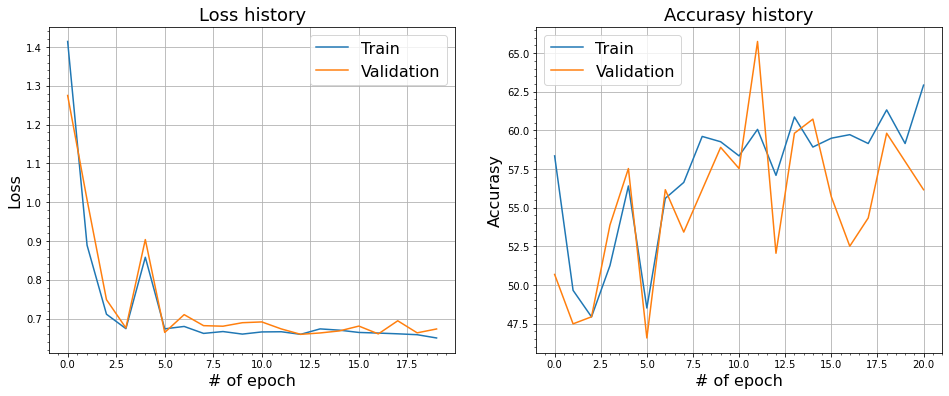

In [ ]:
plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.title('Loss history', fontsize=18)
plt.plot(train_loss_list[1:], label='Train')
plt.plot(val_loss_list[1:], label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accurasy history', fontsize=18)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Accurasy', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()

In [ ]:
#Predtrained model on 1st Dataset with roc_auc metric and sampler for imbalanced Dataset
model = torch.load('/content/drive/MyDrive/Учеба/Diplom/model_classification_weights_roc_auc')

criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

In [ ]:
# training will take ~3 min
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 20

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train_roc_auc(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False) 

Epoch 00/20 || Loss:  Train 1.3385 | Validation 1.1928


  5%|▌         | 1/20 [00:23<07:34, 23.91s/it]

Epoch 01/20 || Loss:  Train 1.4502 | Validation 1.3043


 10%|█         | 2/20 [00:47<07:10, 23.92s/it]

Epoch 02/20 || Loss:  Train 0.8896 | Validation 1.0059


 15%|█▌        | 3/20 [01:11<06:46, 23.91s/it]

Epoch 03/20 || Loss:  Train 0.7166 | Validation 0.7368


 20%|██        | 4/20 [01:35<06:22, 23.91s/it]

Epoch 04/20 || Loss:  Train 0.6731 | Validation 0.6758


 25%|██▌       | 5/20 [01:59<05:58, 23.92s/it]

Epoch 05/20 || Loss:  Train 0.8469 | Validation 0.8915


 30%|███       | 6/20 [02:23<05:34, 23.91s/it]

Epoch 06/20 || Loss:  Train 0.6736 | Validation 0.6641


 35%|███▌      | 7/20 [02:47<05:10, 23.91s/it]

Epoch 07/20 || Loss:  Train 0.6792 | Validation 0.7098


 40%|████      | 8/20 [03:11<04:46, 23.91s/it]

Epoch 08/20 || Loss:  Train 0.6615 | Validation 0.6821


 45%|████▌     | 9/20 [03:35<04:23, 23.91s/it]

Epoch 09/20 || Loss:  Train 0.6665 | Validation 0.6811


 50%|█████     | 10/20 [03:59<03:59, 23.92s/it]

Epoch 10/20 || Loss:  Train 0.6599 | Validation 0.6890


 55%|█████▌    | 11/20 [04:23<03:35, 23.91s/it]

Epoch 11/20 || Loss:  Train 0.6648 | Validation 0.6908


 60%|██████    | 12/20 [04:46<03:11, 23.90s/it]

Epoch 12/20 || Loss:  Train 0.6651 | Validation 0.6731


 65%|██████▌   | 13/20 [05:10<02:47, 23.91s/it]

Epoch 13/20 || Loss:  Train 0.6577 | Validation 0.6590


 70%|███████   | 14/20 [05:34<02:23, 23.91s/it]

Epoch 14/20 || Loss:  Train 0.6721 | Validation 0.6634


 75%|███████▌  | 15/20 [05:58<01:59, 23.90s/it]

Epoch 15/20 || Loss:  Train 0.6734 | Validation 0.6706


 80%|████████  | 16/20 [06:22<01:35, 23.90s/it]

Epoch 16/20 || Loss:  Train 0.6632 | Validation 0.6800


 85%|████████▌ | 17/20 [06:46<01:11, 23.91s/it]

Epoch 17/20 || Loss:  Train 0.6622 | Validation 0.6599


 90%|█████████ | 18/20 [07:10<00:47, 23.91s/it]

Epoch 18/20 || Loss:  Train 0.6598 | Validation 0.6936


 95%|█████████▌| 19/20 [07:34<00:23, 23.91s/it]

Epoch 19/20 || Loss:  Train 0.6575 | Validation 0.6628


100%|██████████| 20/20 [07:58<00:00, 23.91s/it]

Epoch 20/20 || Loss:  Train 0.6491 | Validation 0.6719


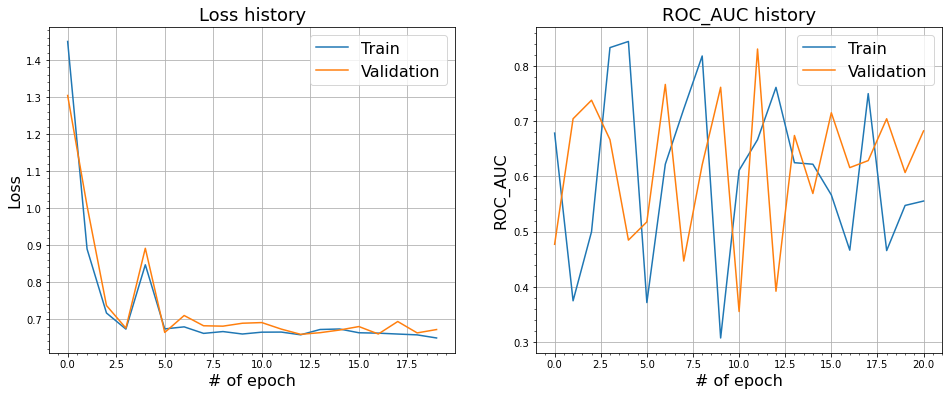

In [ ]:
plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.title('Loss history', fontsize=18)
plt.plot(train_loss_list[1:], label='Train')
plt.plot(val_loss_list[1:], label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()

plt.subplot(1, 2, 2)
plt.title('ROC_AUC history', fontsize=18)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('ROC_AUC', fontsize=16)
plt.legend(fontsize=16)
plt.minorticks_on()
plt.grid()